In [40]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
import pandas as pd

In [41]:
driving_log = pd.read_csv("/Users/ddigges/simulator/driving_log.csv", header=None)

In [42]:
driving_log.head()

,0,1,2,3,4,5,6
0,/Users/ddigges/simulator/IMG/center_2016_12_16...,/Users/ddigges/simulator/IMG/left_2016_12_16_...,/Users/ddigges/simulator/IMG/right_2016_12_16...,0.0,0.0,0,0.000079
1,/Users/ddigges/simulator/IMG/center_2016_12_16...,/Users/ddigges/simulator/IMG/left_2016_12_16_...,/Users/ddigges/simulator/IMG/right_2016_12_16...,0.0,0.0,0,0.000082
2,/Users/ddigges/simulator/IMG/center_2016_12_16...,/Users/ddigges/simulator/IMG/left_2016_12_16_...,/Users/ddigges/simulator/IMG/right_2016_12_16...,0.0,0.0,0,0.000078
3,/Users/ddigges/simulator/IMG/center_2016_12_16...,/Users/ddigges/simulator/IMG/left_2016_12_16_...,/Users/ddigges/simulator/IMG/right_2016_12_16...,0.0,0.0,0,0.000082
4,/Users/ddigges/simulator/IMG/center_2016_12_16...,/Users/ddigges/simulator/IMG/left_2016_12_16_...,/Users/ddigges/simulator/IMG/right_2016_12_16...,0.0,0.0,0,0.000081


In [43]:
driving_log.columns = ["center_image", "left_image", "right_image", "steering_angle", "throttle", "break", "speed"]

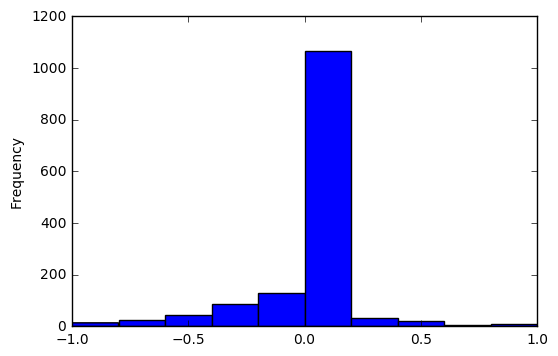

In [44]:
driving_log.steering_angle.plot.hist()

In [45]:
def read_image(file_name):
    return plt.imread(file_name)

In [46]:
val = driving_log[:1]['center_image']

In [47]:
image = read_image(val.values[0])

In [48]:
# IMAGE: 160 x 320 with 3 color channels
image.shape

(160, 320, 3)

In [118]:
def pre_process(image):
    """
        image: input image
        
        - convert to grayscale
        - resize image to half it's original size
    """
    image = np.mean(image, axis=2)
    data_min = np.min(image)
    data_max = np.max(image)
    b = 0.5
    a = -0.5
    
    image = ((b-a) * (image - data_min)/(data_max - data_min)) + a
    return cv2.resize(image, (0,0), fx=0.5, fy=0.5) 

def flatten(image):
    return image.reshape(image.shape[0] * image.shape[1])

In [119]:
a = driving_log[['center_image', 'steering_angle']]    

In [120]:
for i, row in driving_log.iterrows():
    print(row['center_image'], row['steering_angle'])

/Users/ddigges/simulator/IMG/center_2016_12_16_14_26_11_350.jpg 0.0
/Users/ddigges/simulator/IMG/center_2016_12_16_14_26_11_470.jpg 0.0
/Users/ddigges/simulator/IMG/center_2016_12_16_14_26_11_578.jpg 0.0
/Users/ddigges/simulator/IMG/center_2016_12_16_14_26_11_697.jpg 0.0
/Users/ddigges/simulator/IMG/center_2016_12_16_14_26_11_806.jpg 0.0
/Users/ddigges/simulator/IMG/center_2016_12_16_14_26_11_931.jpg 0.0
/Users/ddigges/simulator/IMG/center_2016_12_16_14_26_12_048.jpg 0.0
/Users/ddigges/simulator/IMG/center_2016_12_16_14_26_12_175.jpg 0.0
/Users/ddigges/simulator/IMG/center_2016_12_16_14_26_12_290.jpg 0.0
/Users/ddigges/simulator/IMG/center_2016_12_16_14_26_12_396.jpg 0.0
/Users/ddigges/simulator/IMG/center_2016_12_16_14_26_12_499.jpg 0.0
/Users/ddigges/simulator/IMG/center_2016_12_16_14_26_12_602.jpg 0.0
/Users/ddigges/simulator/IMG/center_2016_12_16_14_26_12_703.jpg 0.0
/Users/ddigges/simulator/IMG/center_2016_12_16_14_26_12_806.jpg 0.0
/Users/ddigges/simulator/IMG/center_2016_12_16_1

In [121]:
# shuffle
driving_log.sample(frac=1).reset_index(drop=True)


,center_image,left_image,right_image,steering_angle,throttle,break,speed
0,/Users/ddigges/simulator/IMG/center_2016_12_16...,/Users/ddigges/simulator/IMG/left_2016_12_16_...,/Users/ddigges/simulator/IMG/right_2016_12_16...,0.492477,1.000000,0,30.167430
1,/Users/ddigges/simulator/IMG/center_2016_12_16...,/Users/ddigges/simulator/IMG/left_2016_12_16_...,/Users/ddigges/simulator/IMG/right_2016_12_16...,0.000000,1.000000,0,30.190240
2,/Users/ddigges/simulator/IMG/center_2016_12_16...,/Users/ddigges/simulator/IMG/left_2016_12_16_...,/Users/ddigges/simulator/IMG/right_2016_12_16...,0.000000,1.000000,0,30.190300
3,/Users/ddigges/simulator/IMG/center_2016_12_16...,/Users/ddigges/simulator/IMG/left_2016_12_16_...,/Users/ddigges/simulator/IMG/right_2016_12_16...,0.000000,1.000000,0,30.190320
4,/Users/ddigges/simulator/IMG/center_2016_12_16...,/Users/ddigges/simulator/IMG/left_2016_12_16_...,/Users/ddigges/simulator/IMG/right_2016_12_16...,0.000000,1.000000,0,30.187080
5,/Users/ddigges/simulator/IMG/center_2016_12_16...,/Users/ddigges/simulator/IMG/left_2016_12_16_...,/Users/ddigges/simulator/IMG/right_2016_12_16...,0.000000,1.000000,0,30.190290
6,/Users/ddigges/simulator/IMG/center_2016_12_16...,/Users/ddigges/simulator/IMG/left_2016_12_16_...,/Users/ddigges/simulator/IMG/right_2016_12_16...,0.000000,1.000000,0,30.190080
7,/Users/ddigges/simulator/IMG/center_2016_12_16...,/Users/ddigges/simulator/IMG/left_2016_12_16_...,/Users/ddigges/simulator/IMG/right_2016_12_16...,0.000000,0.000000,0,28.442050
8,/Users/ddigges/simulator/IMG/center_2016_12_16...,/Users/ddigges/simulator/IMG/left_2016_12_16_...,/Users/ddigges/simulator/IMG/right_2016_12_16...,0.000000,1.000000,0,30.190630
9,/Users/ddigges/simulator/IMG/center_2016_12_16...,/Users/ddigges/simulator/IMG/left_2016_12_16_...,/Users/ddigges/simulator/IMG/right_2016_12_16...,0.000000,1.000000,0,30.191020


In [122]:
driving_log.shape

(1435, 7)

In [140]:
def data_generator(df, batch_size=128):
    n_rows = df.shape[0]
    while True:
        
        for index in range(0, n_rows, batch_size):
            df_batch = df[index: index + batch_size]

            # Ignoring the last batch which is smaller than the requested batch size
            if(df_batch.shape[0] == batch_size):

                X_batch = np.array([flatten(pre_process(mpimg.imread(row['center_image']))) for i, row in df_batch.iterrows()])
                y_batch = np.array([row['steering_angle'] for i, row in df_batch.iterrows()])

                yield X_batch, y_batch


In [141]:
gen = data_generator(driving_log)

In [125]:
X_batch, y_batch = next(gen)

In [126]:
X_batch.shape

(128, 12800)

TypeError: Invalid dimensions for image data

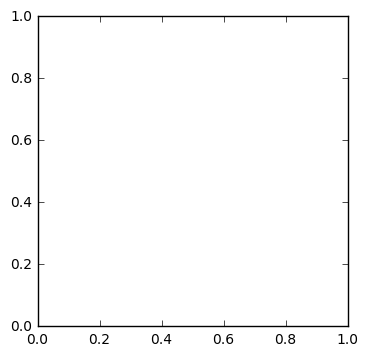

In [127]:
for image in X_batch:
    plt.imshow(image, cmap='gray')
    plt.show()

In [128]:
y_batch.shape

(128,)

(array([  2.,   2.,  13.,  12.,  95.,   0.,   0.,   2.,   0.,   2.]),
 array([-0.6808528, -0.5432305, -0.4056082, -0.2679859, -0.1303636,
         0.0072587,  0.144881 ,  0.2825033,  0.4201256,  0.5577479,
         0.6953702]),
 <a list of 10 Patch objects>)

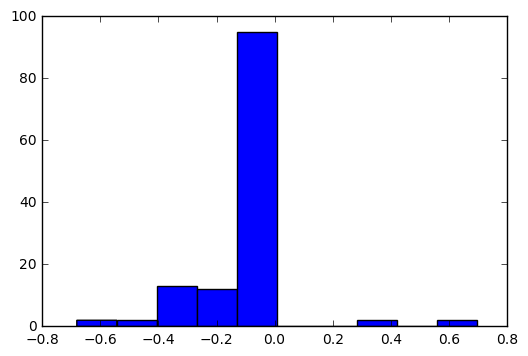

In [129]:
plt.hist(y_batch)

In [142]:
from keras.models import Sequential
from keras.layers import Dense, Activation

In [143]:
hidden_layer_size = 128
output_size = 1
# image_shape_flat = X_batch[0].shape[0] * X_batch[0].shape[1]

In [157]:
model = Sequential()

In [158]:
model.add(Dense(input_dim=image_shape_flat, output_dim=hidden_layer_size))

In [159]:
model.add(Activation("relu"))

In [160]:
model.add(Dense(output_dim=output_size))

In [161]:
model.compile(loss="mean_squared_error", optimizer="sgd", metrics=["accuracy"])

In [162]:
import glob
n = len(glob.glob("/Users/ddigges/simulator/IMG/*"))
batch_size = 128
samples_per_epoch = int(n/batch_size)
nb_epoch = 10

In [163]:
gen = data_generator(driving_log)

model.fit_generator(gen, samples_per_epoch*batch_size, nb_epoch)

Epoch 1/10
4224/4224 [==============================] - 22s - loss: 0.0729 - acc: 0.6918    
Epoch 2/10
4224/4224 [==============================] - 22s - loss: 0.0333 - acc: 0.7138    
Epoch 3/10
4224/4224 [==============================] - 21s - loss: 0.0256 - acc: 0.7138    
Epoch 4/10
4224/4224 [==============================] - 21s - loss: 0.0216 - acc: 0.7138    
Epoch 5/10
4224/4224 [==============================] - 21s - loss: 0.0187 - acc: 0.7145    
Epoch 6/10
4224/4224 [==============================] - 22s - loss: 0.0164 - acc: 0.7150    
Epoch 7/10
4224/4224 [==============================] - 21s - loss: 0.0146 - acc: 0.7159    
Epoch 8/10
4224/4224 [==============================] - 21s - loss: 0.0130 - acc: 0.7159    
Epoch 9/10
4224/4224 [==============================] - 21s - loss: 0.0118 - acc: 0.7161    
Epoch 10/10
4224/4224 [==============================] - 21s - loss: 0.0106 - acc: 0.7166    


In [165]:
model.save_weights("model.h5")

In [168]:
file = open("model.json", "w")
file.write(model.to_json())
file.close()